# Battery Optimization Problem: simple version

The problem setup here is highly simplified: consider a battery operator seeking to optimize its charge and discharge schedule in order to maximizes its profit in the energy market over the operating day. The operator has a forecast of hourly energy market prices ($p_{t}$). The battery has a maximum energy storage capacity of $K$, maximum charge and discharge rate of $\delta$, and one-way efficiency of $\eta$. The battery begins the day fully depleted with a state-of-charge of zero ($S_{0}=0$)
\begin{align} max \sum_{t=1}^{24} \ p_{t}*(d_{t} - c_{t}) \\
    s.t. \\
    0 \le c_{t} \le \delta \\
    0 \le d_{t} \le \delta \\
    \eta * c_{t} - (1/\eta)*d_{t} - S_{t} + S_{t-1} = 0 \\
    0 \le S_{t} \le K \\
    S_{0}=0
\end{align}

Decision variables:
- $d_{t}$ rate of discharge in hour t (MW)
- $c_{t}$ rate of charge in hour t (MW)

State variable: $S_{t}$ battery state of charge at the end of hour t (MWh)

Parameters:
- $p_{t}$ forecasted hourly energy prices (\$/MWh)
- $\delta$ maximum rate of charge/discharge (MW)
- $\eta$ one-way efficiency losses (\%)
- $K$ maximum state of charge (MWh)


In [43]:
# get necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import itertools

In [44]:
# parameter inputs
# hourly price path
p = [23.59,21.36,20.47,20.3,20.26,21.34,23.97,28.34,31.6,29.18,27.54,25.79,
 25.22,27.17,29.56,31.74,33.81,40.99,41,40.65,37.46,32.13,28.97,26.88]
# battery maximum charge/discharge rates
w = 5
eff = 0.95
# battery maximum energy capacity
K = 10
# battery starting energy level
S_0 = 0
# hours of optimization horizon
t_max = 24

# decision variables
# x will be a 72x1 vector that consist of the three variables charge(c_t), discharge(d_t), and energy levels (S_t) over 24 hours
# objective function coefficients
c = np.concatenate((-1*np.array(p),np.array(p),np.zeros(t_max)))

# constraints
# lb vector
lb = np.zeros(3*t_max)
# ub vector
ub = np.concatenate((np.full(t_max,w),np.full(t_max,w),np.full(t_max,K)))
bounds = np.c_[lb,ub]

# A_eq equality contraints matrix
A_eq1 = np.hstack((np.diag(np.full(t_max,eff)),np.diag(np.full(t_max,-1/eff))))
A_eq2 = np.diag(np.full(t_max-1,1),-1)
np.fill_diagonal(A_eq2,-1)
A_eq = np.hstack((A_eq1,A_eq2))
b_eq = np.transpose(np.zeros(t_max))

# run optimization problem
simple_opt = linprog(c=-c, A_eq=A_eq,b_eq=b_eq,bounds=bounds)
simple_opt.status # status shoule be 0, meaning terminated successfully

0

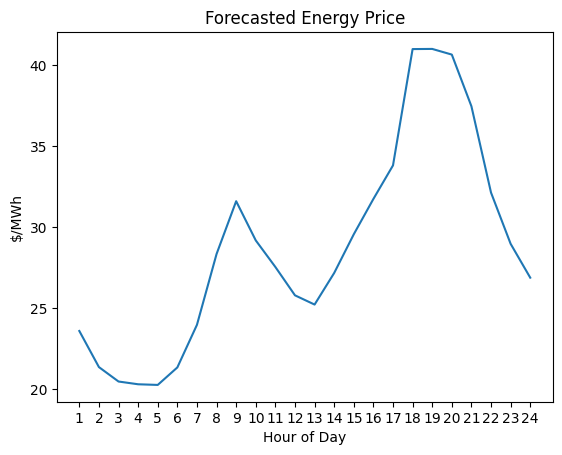

In [45]:
# plot forecasted prices
tm = np.arange(1,t_max+1) # hour endings
plt_price = plt.plot(tm,p)
plt.title('Forecasted Energy Price')
plt.xlabel('Hour of Day')
plt.ylabel('$/MWh')
plt.xticks(tm)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

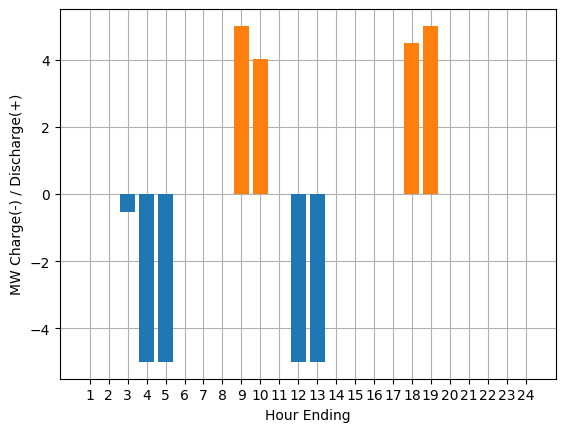

In [46]:
# plot optimal charge and discharge rate
plt.grid(zorder=0)
x_opt = simple_opt.x
plt_opt = plt.bar(tm,-x_opt[0:t_max],zorder=3) + plt.bar(tm,x_opt[t_max:t_max*2],zorder=3)
plt.xticks(tm)
plt.xlabel('Hour Ending')
plt.ylabel('MW Charge(-) / Discharge(+)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

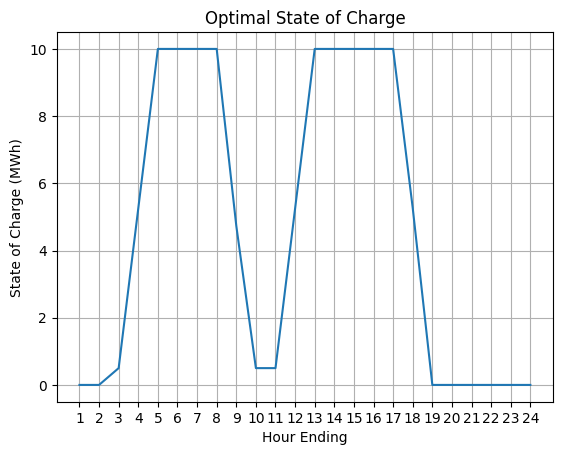

In [49]:
# plot state of charge over the operating day
tm = np.arange(1,t_max+1)
plt.grid(zorder=0)
plt_opt = plt.plot(tm,x_opt[t_max*2:t_max*3],zorder=3) 
plt.xticks(tm)
plt.xlabel('Hour Ending')
plt.ylabel('State of Charge (MWh)')
plt.title('Optimal State of Charge')
plt.show

In [48]:
print('Expected Total Daily Profit: $'+ str(-1*round(simple_opt.fun,2)))
print('Clearly, with these prices there is not money in the energy market.')

Expected Total Daily Profit: $196.28
Clearly, with these prices there is not money in the energy market.
